## 正则化

### L1正则化

In [1]:
import numpy as np
import matplotlib.pyplot as plt
# 生成数据集
np.random.seed(42)
X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)
# 添加偏置项
X_b = np.c_[np.ones((100, 1)), X]

定义损失函数（包含L1正则化）

In [2]:
def compute_loss(X, y, theta, l1_lambda):
    m = len(y)
    predictions = X.dot(theta)
    mse_loss = (1/(2*m)) * np.sum((predictions - y)**2)
    l1_penalty = l1_lambda * np.sum(np.abs(theta))
    total_loss = mse_loss + l1_penalty  # L1正则化
    return total_loss

定义梯度下降（包含L1正则化）

In [3]:
def gradient_descent(X, y, theta, learning_rate, l1_lambda, n_iterations):
    m = len(y)
    loss_history = []

    for iteration in range(n_iterations):
        predictions = X.dot(theta)
        errors = predictions - y
        gradients = (1/m) * X.T.dot(errors)

        # 添加L1正则化的梯度
        l1_gradients = l1_lambda * np.sign(theta)
        gradients += l1_gradients

        theta -= learning_rate * gradients
        loss = compute_loss(X, y, theta, l1_lambda)
        loss_history.append(loss)

    return theta, loss_history

In [4]:
# 初始化参数
theta = np.random.randn(2, 1)
learning_rate = 0.1
l1_lambda = 0.1
n_iterations = 1000

# 运行梯度下降
theta_optimized, loss_history = gradient_descent(
    X_b, y, theta, learning_rate, l1_lambda, n_iterations)

# 打印优化后的参数
print("Optimized theta:", theta_optimized)

Optimized theta: [[4.13109843]
 [2.75309622]]


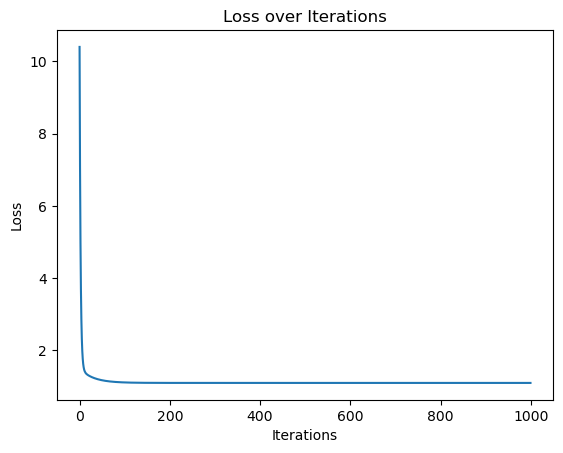

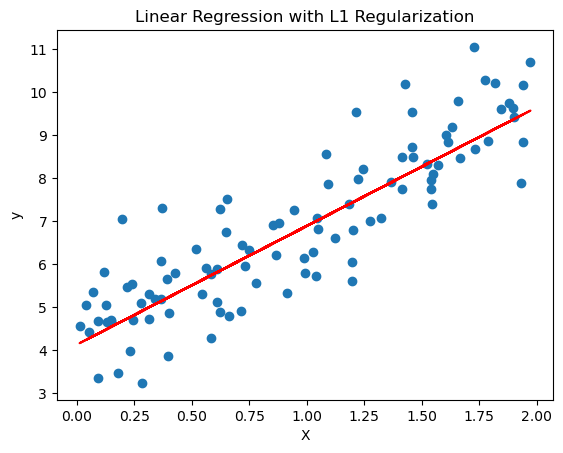

In [5]:
# 绘制损失函数的变化曲线
plt.plot(loss_history)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss over Iterations')
plt.show()

# 绘制数据和拟合直线
plt.scatter(X, y)
plt.plot(X, X_b.dot(theta_optimized), color='red')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Linear Regression with L1 Regularization')
plt.show()

## Batch Normalization

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
class ManualBatchNorm1d(nn.Module):
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        super(ManualBatchNorm1d, self).__init__()
        self.num_features = num_features
        self.eps = eps  # 防止除零错误的小常数
        self.momentum = momentum  # 用于更新全局均值和方差的动量

        # 可学习的参数
        self.gamma = nn.Parameter(torch.ones(num_features))  # 缩放因子
        self.beta = nn.Parameter(torch.zeros(num_features))  # 平移因子

        # 全局均值和方差（用于测试阶段）
        self.register_buffer('running_mean', torch.zeros(num_features))
        self.register_buffer('running_var', torch.ones(num_features))

    def forward(self, x):
        # 使用EMA指数移动平均更新全局均值和方差
        if self.training:
            # 训练阶段：使用 mini-batch 的均值和方差
            mean = x.mean(dim=0)  # 计算均值
            var = x.var(dim=0, unbiased=False)  # 计算方差

            # 更新全局均值和方差
            self.running_mean = (1 - self.momentum) * \
                self.running_mean + self.momentum * mean
            self.running_var = (1 - self.momentum) * \
                self.running_var + self.momentum * var
        else:
            # 测试阶段：使用全局均值和方差
            mean = self.running_mean
            var = self.running_var

        # 标准化
        x_normalized = (x - mean) / torch.sqrt(var + self.eps)

        # 缩放和平移
        out = self.gamma * x_normalized + self.beta
        return out

In [5]:
# 设置随机种子以确保结果可重复
torch.manual_seed(42)

# 生成随机数据
num_samples = 1000
num_features = 20
num_classes = 2

# 随机生成输入数据和标签
X = torch.randn(num_samples, num_features)  # 1000 个样本，每个样本 20 个特征
y = torch.randint(0, num_classes, (num_samples,))  # 1000 个标签，二分类问题

# 将数据封装为 DataLoader
dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [6]:
# 定义一个简单的全连接神经网络
class MLPWithManualBN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLPWithManualBN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.bn1 = ManualBatchNorm1d(hidden_size)  # 使用手动实现的 BatchNorm1d
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)  # 在激活函数前应用 Batch Normalization
        x = self.relu(x)
        x = self.fc2(x)
        return x


# 初始化模型、损失函数和优化器
input_size = 20
hidden_size = 64
output_size = 2

model = MLPWithManualBN(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 训练过程
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # 设置为训练模式
    for batch_X, batch_y in dataloader:
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

# 测试模式
model.eval()  # 设置为测试模式
with torch.no_grad():
    test_outputs = model(X)
    print("Test outputs:", test_outputs)

Epoch [1/10], Loss: 0.8752
Epoch [2/10], Loss: 0.6493
Epoch [3/10], Loss: 0.7116
Epoch [4/10], Loss: 0.8060
Epoch [5/10], Loss: 0.6693
Epoch [6/10], Loss: 0.7092
Epoch [7/10], Loss: 0.6287
Epoch [8/10], Loss: 0.6880
Epoch [9/10], Loss: 0.8254
Epoch [10/10], Loss: 0.6806
Test outputs: tensor([[ 0.2011,  0.2478],
        [-0.0747,  0.4197],
        [-0.8003,  0.8320],
        ...,
        [ 0.5658,  0.1328],
        [ 0.0897, -0.1440],
        [ 0.2887,  0.2302]])
